$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 8: Convolutional Neural Networks
<a id=part4></a>

In this part we will explore convolution networks. We'll implement a common block-based deep CNN pattern with an without residual connections.

In [1]:
import os
import re
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import unittest
import torch
import torchvision
import torchvision.transforms as tvtf

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.rcParams.update({'font.size': 12})
test = unittest.TestCase()

## Convolutional layers and networks
<a id=part3_1></a>

Convolutional layers are the most essential building blocks of the state of the art deep learning image classification models and also play an important role in many other tasks.
As we saw in the tutorial, when applied to images, convolutional layers operate on and produce volumes (3D tensors) of activations.

A convenient way to interpret convolutional layers for images is as a collection of 3D learnable filters,
each of which operates on a small spatial region of the input volume.
Each filter is convolved with the input volume ("slides over it"),
and a dot product is computed at each location followed by a non-linearity which produces one activation.
All these activations produce a 2D plane known as a **feature map**.
Multiple feature maps (one for each filter) comprise the output volume.

<img src="imgs/cnn_filters.png" width="600" />


A crucial property of convolutional layers is their translation equivariance, i.e. shifting the input results in
and equivalently shifted output.
This produces the ability to detect features regardless of their spatial location in the input.

Convolutional network architectures usually follow a pattern basic repeating blocks: one or more convolution layers, each followed by a non-linearity (generally ReLU) and then a pooling layer to reduce spatial dimensions. Usually, the number of convolutional filters increases the deeper they are in the network.
These layers are meant to extract features from the input.
Then, one or more fully-connected layers is used to combine the extracted features into the required number of output class scores.

## Building convolutional networks with PyTorch
<a id=part3_2></a>

PyTorch provides all the basic building blocks needed for creating a convolutional arcitecture within the [`torch.nn`](https://pytorch.org/docs/stable/nn.html) package.
Let's use them to create a basic convolutional network with the following architecture pattern:

    [(CONV -> ACT)*P -> POOL]*(N/P) -> (FC -> ACT)*M -> FC

Here $N$ is the total number of convolutional layers,
$P$ specifies how many convolutions to perform before each pooling layer
and $M$ specifies the number of hidden fully-connected layers before the final output layer.

In [3]:
from src.cnn import CNN

test_params = [
    dict(
        in_size=(3,100,100), out_classes=10,
        channels=[32]*4, pool_every=2, hidden_dims=[100]*2,
        conv_params=dict(kernel_size=3, stride=1, padding=1),
        activation_type='relu', activation_params=dict(),
        pooling_type='max', pooling_params=dict(kernel_size=2),
    ),
    dict(
        in_size=(3,100,100), out_classes=10,
        channels=[32]*4, pool_every=2, hidden_dims=[100]*2,
        conv_params=dict(kernel_size=5, stride=2, padding=3),
        activation_type='lrelu', activation_params=dict(negative_slope=0.05),
        pooling_type='avg', pooling_params=dict(kernel_size=3),
    ),
    dict(
        in_size=(3,100,100), out_classes=3,
        channels=[16]*5, pool_every=3, hidden_dims=[100]*1,
        conv_params=dict(kernel_size=2, stride=2, padding=2),
        activation_type='lrelu', activation_params=dict(negative_slope=0.1),
        pooling_type='max', pooling_params=dict(kernel_size=2),
    ),
]

for i, params in enumerate(test_params):
    torch.manual_seed(seed)
    net = CNN(**params)
    print(f"\n=== test {i=} ===")
    print(net)

    torch.manual_seed(seed)
    test_out = net(torch.ones(1, 3, 100, 100))
    print(f'{test_out=}')

    expected_out = torch.load(f'tests/assets/expected_conv_out_{i:02d}.pt')
    print(f'max_diff={torch.max(torch.abs(test_out - expected_out)).item()}')
    test.assertTrue(torch.allclose(test_out, expected_out, atol=1e-3))


=== test i=0 ===
CNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (mlp): MLP(
    (fc_layers): Sequential(
      (0): Linear(in_features=20000, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): ReLU()
    )
  )
  (fcl): Linear(in_features=100, out_features=10, bias=True)
)
test_out=tensor([[ 0.0745, -0.1058,  0.0928,  0.0476,  0.0057,  0.0051,  0.0938, -0.0582,
          0.0573,  0.0583]], grad_f

As before, we'll wrap our model with a `Classifier` that provides the necessary functionality for calculating probability scores and obtaining class label predictions.
This time, we'll use a simple approach that simply selects the class with the highest score.

In [4]:
from src.classifier import ArgMaxClassifier

model = ArgMaxClassifier(model=CNN(**test_params[0]))

test_image = torch.randint(low=0, high=256, size=(3, 100, 100), dtype=torch.float).unsqueeze(0)
test.assertEqual(model.classify(test_image).shape, (1,))
test.assertEqual(model.predict_proba(test_image).shape, (1, 10))
test.assertAlmostEqual(torch.sum(model.predict_proba(test_image)).item(), 1.0, delta=1e-3)

Let's now load CIFAR-10 to use as our dataset.

In [5]:
data_dir = os.path.expanduser('~/.pytorch-datasets')
ds_train = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=True, transform=tvtf.ToTensor())
ds_test = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=False, transform=tvtf.ToTensor())

print(f'Train: {len(ds_train)} samples')
print(f'Test: {len(ds_test)} samples')

x0,_ = ds_train[0]
in_size = x0.shape
num_classes = 10
print('input image size =', in_size)

Files already downloaded and verified
Files already downloaded and verified
Train: 50000 samples
Test: 10000 samples
input image size = torch.Size([3, 32, 32])


Now as usual, as a sanity test let's make sure we can overfit a tiny dataset with our model. But first we need to adapt our `Trainer` for PyTorch models.

In [6]:
from src.training import ClassifierTrainer
from src.answers import part8_optim_hp

torch.manual_seed(seed)

# Define a tiny part of the CIFAR-10 dataset to overfit it
batch_size = 2
max_batches = 25
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=False)

# Create model, loss and optimizer instances
model = ArgMaxClassifier(
    model=CNN(
        in_size, num_classes, channels=[32], pool_every=1, hidden_dims=[100],
        conv_params=dict(kernel_size=3, stride=1, padding=1),
        pooling_params=dict(kernel_size=2),
    )
)

hp_optim = part8_optim_hp()
loss_fn = hp_optim.pop('loss_fn')
optimizer = torch.optim.SGD(params=model.parameters(), **hp_optim)

# Use ClassifierTrainer to run only the training loop a few times.
trainer = ClassifierTrainer(model, loss_fn, optimizer, device)
best_acc = 0
for i in range(25):
    res = trainer.train_epoch(dl_train, max_batches=max_batches, verbose=(i%5==0))
    best_acc = res.accuracy if res.accuracy > best_acc else best_acc
    
# Test overfitting
test.assertGreaterEqual(best_acc, 90)

train_batch:   0%|          | 0/25 [00:00<?, ?it/s]

train_batch:   0%|          | 0/25 [00:00<?, ?it/s]

train_batch:   0%|          | 0/25 [00:00<?, ?it/s]

train_batch:   0%|          | 0/25 [00:00<?, ?it/s]

train_batch:   0%|          | 0/25 [00:00<?, ?it/s]

### Residual Networks

A very common addition to the basic convolutional architecture described above are **shortcut connections**.
First proposed by [He et al. (2016)](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf), this simple addition has been shown to be crucial
ingredient in order to achieve effective learning with very deep networks.
Virtually all state of the art image classification models from recent years use this technique.

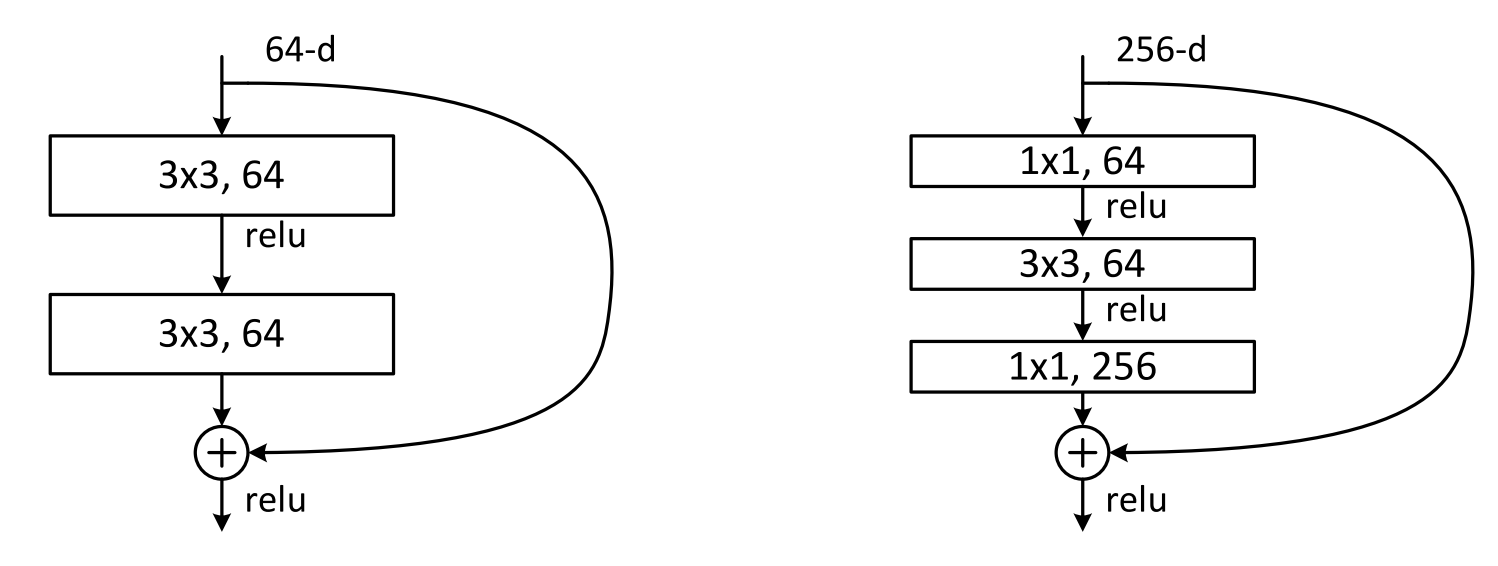The idea is to add an shortcut, or skip, around every two or more convolutional layers:

<img src="imgs/resnet_block2.png" width="700" />

This adds an easy way for the network to learn identity mappings: set the weight values to be very small.
The consequence is that the convolutional layers to learn a **residual** mapping, i.e. some delta that is applied
to the identity map, instead of actually learning a completely new mapping from scratch.


Lets start by implementing a general residual block, representing a structure similar to the above diagrams.
Our residual block will be composed of:
- A "main path" with some number of convolutional layers with ReLU between them. Optionally, we'll also apply dropout and  batch normalization layers (in this order) between the convolutions, before the ReLU.
- A "shortcut path" implementing an identity mapping around the main path. In case of a different number of input/output channels, the shortcut path should contain an additional `1x1` convolution to project the channel dimension.
- The sum of the main and shortcut paths output is passed though a ReLU and returned.

In [7]:
from src.cnn import ResidualBlock

torch.manual_seed(seed)

resblock = ResidualBlock(
    in_channels=3, channels=[6, 4]*2, kernel_sizes=[3, 5]*2,
    batchnorm=True, dropout=0.2
)
print(resblock)

torch.manual_seed(seed)
test_out = resblock(torch.ones(1, 3, 32, 32))
print(f'{test_out.shape=}')

expected_out = torch.load('tests/assets/expected_resblock_out.pt')
print(f'max_diff={torch.max(torch.abs(test_out - expected_out)).item()}')
test.assertTrue(torch.allclose(test_out, expected_out, atol=1e-3))

ResidualBlock(
  (main_path): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout2d(p=0.2, inplace=False)
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(6, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): Dropout2d(p=0.2, inplace=False)
    (6): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(4, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Dropout2d(p=0.2, inplace=False)
    (10): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(6, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (shortcut_path): Sequential(
    (0): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
)
test_out.shape=torch.Size([1, 4, 32, 32])
max_diff=5.960464477539062e-07


#### Bottleneck Blocks

In the ResNet Block diagram shown above, the right block is called a bottleneck block.
This type of block is mainly used deep in the network, where the feature space becomes increasingly high-dimensional (i.e. there are many channels).

Instead of applying a KxK conv layer on the original input channels, a bottleneck block
first projects to a lower number of features (channels), applies the KxK conv on the result, and then projects back to the original feature space.
Both projections are performed with 1x1 convolutions.

In [8]:
from src.cnn import ResidualBottleneckBlock

torch.manual_seed(seed)
resblock_bn = ResidualBottleneckBlock(
    in_out_channels=256, inner_channels=[64, 32, 64], inner_kernel_sizes=[3, 5, 3],
    batchnorm=False, dropout=0.1, activation_type="lrelu"
)
print(resblock_bn)

# Test a forward pass
torch.manual_seed(seed)
test_in  = torch.ones(1, 256, 32, 32)
test_out = resblock_bn(test_in)
print(f'{test_out.shape=}')
assert test_out.shape == test_in.shape 

expected_out = torch.load('tests/assets/expected_resblock_bn_out.pt')
print(f'max_diff={torch.max(torch.abs(test_out - expected_out)).item()}')
test.assertTrue(torch.allclose(test_out, expected_out, atol=1e-3))

ResidualBottleneckBlock(
  (main_path): Sequential(
    (0): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): Dropout2d(p=0.1, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Dropout2d(p=0.1, inplace=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): Dropout2d(p=0.1, inplace=False)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Dropout2d(p=0.1, inplace=False)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (shortcut_path): Sequential(
    (0): Identity()
  )
)
test_out.shape=torch.Size([1, 256, 32, 32])
max_diff=1.1920928955078125e-07


Now, based on the `ResidualBlock`, we'll implement our own variation of a residual network (ResNet),
with the following architecture:

    [-> (CONV -> ACT)*P -> POOL]*(N/P) -> (FC -> ACT)*M -> FC
     \------- SKIP ------/
     
Note that $N$, $P$ and $M$ are as before, however now $P$ also controls the number of convolutional layers to add a skip-connection to.

In [9]:
from src.cnn import ResNet

test_params = [
    dict(
        in_size=(3,100,100), out_classes=10, channels=[32, 64]*3,
        pool_every=4, hidden_dims=[100]*2,
        activation_type='lrelu', activation_params=dict(negative_slope=0.01),
        pooling_type='avg', pooling_params=dict(kernel_size=2),
        batchnorm=True, dropout=0.1,
        bottleneck=False
    ),
    dict(
        # create 64->16->64 bottlenecks
        in_size=(3,100,100), out_classes=5, channels=[64, 16, 64]*4,
        pool_every=3, hidden_dims=[64]*1,
        activation_type='tanh',
        pooling_type='max', pooling_params=dict(kernel_size=2),
        batchnorm=True, dropout=0.1,
        bottleneck=True
    )
]

for i, params in enumerate(test_params):
    torch.manual_seed(seed)
    net = ResNet(**params)
    print(f"\n=== test {i=} ===")
    print(net)

    torch.manual_seed(seed)
    test_out = net(torch.ones(1, 3, 100, 100))
    print(f'{test_out=}')
    
    expected_out = torch.load(f'tests/assets/expected_resnet_out_{i:02d}.pt')
    print(f'max_diff={torch.max(torch.abs(test_out - expected_out)).item()}')
    test.assertTrue(torch.allclose(test_out, expected_out, atol=1e-3))


=== test i=0 ===
ResNet(
  (feature_extractor): Sequential(
    (0): ResidualBlock(
      (main_path): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Dropout2d(p=0.1, inplace=False)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): LeakyReLU(negative_slope=0.01)
        (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): Dropout2d(p=0.1, inplace=False)
        (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): LeakyReLU(negative_slope=0.01)
        (8): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (9): Dropout2d(p=0.1, inplace=False)
        (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (11): LeakyReLU(negative_slope=0.01)
        (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (short

## Questions
<a id=part3_4></a>

In [1]:
from utils.answers import display_answer
import src.answers

### Question 1

Consider the bottleneck block from the right side of the ResNet diagram above.
Compare it to a regular block that performs a two 3x3 convs directly on the 256-channel input (i.e. as shown in the left side of the diagram, with a different number of channels).
Explain the differences between the regular block and the bottleneck block in terms of:

1. Number of parameters. Calculate the exact numbers for these two examples.
2. Number of floating point operations required to compute an output (qualitative assessment).
3. Ability to combine the input: (1) spatially (within feature maps); (2) across feature maps.


In [2]:
display_answer(src.answers.part8_q1)



1. Following the notation from the tutorial, The number of parameters per convolutional layer is $(F^2*Cin+1)*Cout$
 Hence for the regular block we get $(3^2*256+1)*256 + (3^2*256+1)*256 = 1,180,160$
 and for the bottleneck block we get $(1^2*256+1)*64 + (3^2*64+1)*64 + (1^2*64+1)*256= 70,016$
2. From the previous section we can conclude that there is more floating point operations in the regular case (compare
 to bottleneck), This is because operations are performed at higher dimensions comparing the params $(F, Cin, Cout)$
  in each case.
3. In the regular case we have the ability to combine the input within feature maps and across feature maps (as we saw
 in the tutorial). In the bottleneck case in the layers (1x1  64) we combine only across feature maps because of the
 kernel size 1x1. 
